# Shifted Windows Image Restoration (SwinIR)

## Clone the SwinIR Repository

In [1]:
!git clone https://github.com/JingyunLiang/SwinIR.git

Cloning into 'SwinIR'...
remote: Enumerating objects: 333, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 333 (delta 6), reused 2 (delta 2), pack-reused 323 (from 2)
Receiving objects: 100% (333/333), 29.84 MiB | 13.86 MiB/s, done.
Resolving deltas: 100% (119/119), done.


## Load the Dataset and Preprocess it

In [2]:
import cv2
import torch
import numpy as np
from glob import glob
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm
import os

# Dataset path and categories
dataset_path = "/kaggle/input/dataset1/Dataset"
categories = ["glioma", "healthy", "meningioma"]  # Modify based on your dataset
target_size = (512, 512)  # Target image size for training (256x256)
# Define the device: 'cuda' if GPU is available, otherwise use 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class MRIImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, target_size)  # Resize to 256x256

        if self.transform:
            img = self.transform(img)

        return img

def preprocess_images():
    X_lr, X_hr = [], []
    target_size_hr = (512, 512)  # HR target size
    target_size_lr = (256, 256)   # LR input size (will be upscaled to 512×512)

    for category in categories:
        category_path = os.path.join(dataset_path, category)
        image_paths = sorted(glob(os.path.join(category_path, '*')))
        np.random.shuffle(image_paths)

        print(f"\n🔁 Processing {len(image_paths)} images from {category}...")

        for img_path in tqdm(image_paths):
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue

                # Resize to HR (512x512) and normalize
                hr_img = cv2.resize(img, target_size_hr).astype('float32') / 255.0

                # Generate Low-Resolution image (256x256)
                lr_img = cv2.resize(img, target_size_lr, interpolation=cv2.INTER_CUBIC)
                lr_img = lr_img.astype('float32') / 255.0

                # Append to lists (add channel dimension)
                X_lr.append(lr_img[..., np.newaxis])  # [256, 256, 1]
                X_hr.append(hr_img[..., np.newaxis])   # [512, 512, 1]

            except Exception as e:
                print(f"❌ Error processing {img_path}: {e}")

    return np.array(X_lr), np.array(X_hr)

# Run Preprocessing
X_train_lr, X_train_hr = preprocess_images()
print("✅ Preprocessing complete!")
print("Low-Resolution shape:", X_train_lr.shape)
print("High-Resolution shape:", X_train_hr.shape)

# Convert to PyTorch tensors
import torch
X_train_lr_tensor = torch.tensor(X_train_lr, dtype=torch.float32).to(device)
X_train_hr_tensor = torch.tensor(X_train_hr, dtype=torch.float32).to(device)

# Create a DataLoader for batching
train_dataset = DataLoader(list(zip(X_train_lr_tensor, X_train_hr_tensor)), batch_size=2, shuffle=True)


🔁 Processing 700 images from glioma...


100%|██████████| 700/700 [00:06<00:00, 104.10it/s]



🔁 Processing 196 images from healthy...


100%|██████████| 196/196 [00:01<00:00, 104.75it/s]



🔁 Processing 700 images from meningioma...


100%|██████████| 700/700 [00:06<00:00, 108.08it/s]


✅ Preprocessing complete!
Low-Resolution shape: (1596, 256, 256, 1)
High-Resolution shape: (1596, 512, 512, 1)


## Model Architecture

In [3]:
import torch
import torch.nn as nn
from SwinIR.models.network_swinir import SwinIR  # Assuming 'network_swinir.py' is in the 'models' folder

# Set device to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize SwinIR for grayscale medical image super-resolution
model = SwinIR(
    img_size=256,               # Low-resolution input size
    in_chans=1,                 # 1 channel for grayscale (CRITICAL)
    embed_dim=60,               # Reduced from default 96 to save memory
    depths=[5, 5, 5, 5],        # Number of RSTB blocks in each stage
    num_heads=[5, 5, 5, 5],     # Attention heads (reduced from default 6)
    window_size=8,              # Window size for local attention
    mlp_ratio=2.0,              # Ratio of MLP hidden dim to embedding dim
    upscale=2,                  # 2x super-resolution (256→512)
    upsampler='pixelshuffledirect',  # Efficient upsampling
    img_range=1.,               # Input range [0,1] (matches your normalization)
    resi_connection='1conv'     # Single conv for residual connection
).to(device)

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
print(model)

SwinIR(
  (conv_first): Conv2d(1, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (patch_embed): PatchEmbed(
    (norm): LayerNorm((60,), eps=1e-05, elementwise_affine=True)
  )
  (patch_unembed): PatchUnEmbed()
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): RSTB(
      (residual_group): BasicLayer(
        dim=60, input_resolution=(256, 256), depth=5
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            dim=60, input_resolution=(256, 256), num_heads=5, window_size=8, shift_size=0, mlp_ratio=2.0
            (norm1): LayerNorm((60,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              dim=60, window_size=(8, 8), num_heads=5
              (qkv): Linear(in_features=60, out_features=180, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=60, out_features=60, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
          

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from skimage.metrics import structural_similarity as ssim
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
from torchmetrics.image import PeakSignalNoiseRatio
import os

In [6]:
# Initialize PSNR metric
psnr = PeakSignalNoiseRatio().to(device)


In [7]:
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(sr_images, hr_images):
    # Convert images to numpy arrays (if needed) and squeeze to remove channel dimension
    sr_images = sr_images.squeeze(1).cpu().detach().numpy()  # [batch_size, height, width]
    hr_images = hr_images.squeeze(1).cpu().detach().numpy()  # [batch_size, height, width]

    # Initialize the SSIM score
    ssim_value = 0

    # Compute SSIM for each image in the batch
    for i in range(len(sr_images)):
        ssim_value += ssim(sr_images[i], hr_images[i], data_range=sr_images[i].max() - sr_images[i].min(), win_size=3)  # Set win_size to 3

    return ssim_value / len(sr_images)  # Return the average SSIM value

In [8]:
# Function to save checkpoint
checkpoint_path = '/kaggle/working/swinir_checkpoint.pth'
def save_checkpoint(epoch, model, optimizer, loss, filename=checkpoint_path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss  # Optional: to track loss
    }
    torch.save(checkpoint, filename)

In [9]:
checkpoint_path = '/kaggle/input/swinir/pytorch/default/1/swinir_checkpoint (1).pth'
def load_checkpoint(model, optimizer, filename=checkpoint_path):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model, optimizer, epoch, loss

## Model Training and Evaluation

In [12]:
#Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for super-resolution
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Path to save the latest model checkpoint
checkpoint_path = '/kaggle/input/swinir/pytorch/default/1/swinir_checkpoint (1).pth'

#for to load the existing model,
try:
    model, optimizer, start_epoch, loss = load_checkpoint(model, optimizer)
    print(f"Resumed from epoch {start_epoch}, loss: {loss:.4f}")
except FileNotFoundError:
    start_epoch = 0  # Start from the first epoch if no checkpoint is found
    print("No checkpoint found, starting training from scratch.")


start_epoch = 0
num_epochs = 19

# Training Loop
for epoch in range(start_epoch, num_epochs):
    model.train()  # Set model to training mode
    total_loss = 0
    total_psnr = 0
    total_ssim = 0

    for i, (lr_images, hr_images) in enumerate(train_dataset):
        lr_images, hr_images = lr_images.to(device), hr_images.to(device)

        # Print initial shape for debugging
        #print(f"Initial LR shape: {lr_images.shape}, HR shape: {hr_images.shape}")

        # Convert from [batch, height, width, channels] to [batch, channels, height, width]
        if len(lr_images.shape) == 4 and lr_images.shape[-1] in [1, 3]:  # Channels last format
            lr_images = lr_images.permute(0, 3, 1, 2)  # [batch, channels, height, width]
            hr_images = hr_images.permute(0, 3, 1, 2)

        #print(f"After permute shape - LR: {lr_images.shape}, HR: {hr_images.shape}")

        # Ensure images are compatible with window size (padding if needed)
        lr_images = model.check_image_size(lr_images)
        hr_images = model.check_image_size(hr_images)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass: Get the super-resolved images from the model
        sr_images = model(lr_images)

        # Convert sr_images to have 1 channel (grayscale) to match hr_images
        sr_images = sr_images[:, 0, :, :].unsqueeze(1)  # Select the first channel and add a dimension

        # Compute the loss (MSE)
        loss = criterion(sr_images, hr_images)
        total_loss += loss.item()

        # Compute PSNR
        psnr_value = psnr(sr_images, hr_images)  # Calculate PSNR
        total_psnr += psnr_value.item()

        # Compute SSIM
        ssim_value = calculate_ssim(sr_images, hr_images)  # Calculate SSIM
        total_ssim += ssim_value

        # Backpropagation
        loss.backward()
        optimizer.step()
        print(i)

    # Calculate average metrics for the epoch
    avg_loss = total_loss / len(train_dataset)
    avg_psnr = total_psnr / len(train_dataset)
    avg_ssim = total_ssim / len(train_dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, PSNR: {avg_psnr:.4f}, SSIM: {avg_ssim:.4f}")

    # Save checkpoint after each epoch
    #torch.save(model.state_dict(), checkpoint_path)
    #print(f"Checkpoint saved: {checkpoint_path}")

    # Save checkpoint after each epoch
    save_checkpoint(epoch, model, optimizer, avg_loss)
    print(f"Checkpoint saved: {checkpoint_path}")



final_model_path = '/kaggle/working/final_swinir_model.pth'  # Final model path
torch.save(model.state_dict(), final_model_path)
print(f"Final model saved to {final_model_path}")

/tmp/ipykernel_31/1717022548.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


No checkpoint found, starting training from scratch.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
2

KeyboardInterrupt: 

In [13]:
final_model_path = '/kaggle/working/final_swinir_model.pth'  # Final model path
torch.save(model.state_dict(), final_model_path)
print(f"Final model saved to {final_model_path}")

Final model saved to /kaggle/working/final_swinir_model.pth


## Predictions 

/tmp/ipykernel_31/2892099570.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


Model loaded from /kaggle/working/final_swinir_model.pth
Prediction saved as /kaggle/working/predicted_hr_image.jpg


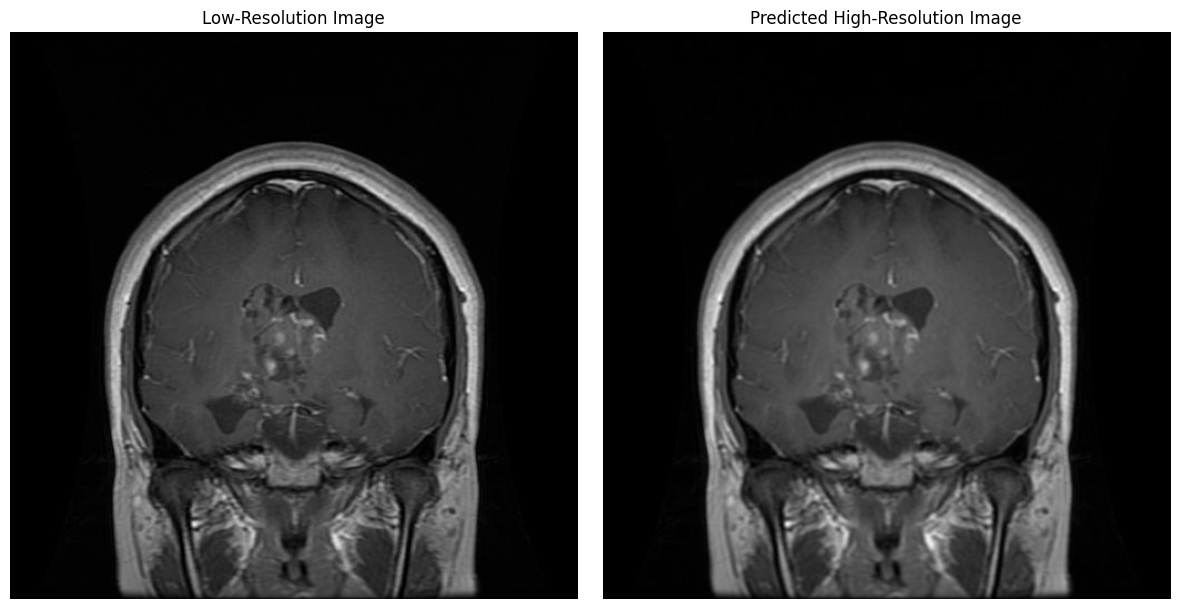

In [17]:
import torch
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# Load the model
def load_model(model, checkpoint_path, device='cuda'):
    """
    Loads the model from a checkpoint for inference.
    Args:
        model: The model to load
        checkpoint_path (str): Path to the saved model checkpoint
        device (str): Device ('cuda' or 'cpu') for model computation
    """
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()
    print(f"Model loaded from {checkpoint_path}")
    return model


# Prediction Function to use the trained model
def predict(model, lr_image, device='cuda'):
    """
    Perform image super-resolution using the trained model.
    Args:
        model: The trained SwinIR model
        lr_image (ndarray): Low-resolution image as a NumPy array
        device (str): Device ('cuda' or 'cpu') for model computation
    
    Returns:
        hr_image (ndarray): Super-resolved high-resolution image
    """
    # Check if lr_image is a PyTorch tensor; if it is, convert it to NumPy array
    if isinstance(lr_image, torch.Tensor):
        lr_image = lr_image.cpu().numpy()

    # Convert the image to a PyTorch tensor
    lr_tensor = torch.from_numpy(lr_image).float().unsqueeze(0).unsqueeze(0).to(device)  # (1, 1, H, W)
    
    # Forward pass to get the super-resolved image
    with torch.no_grad():
        sr_tensor = model(lr_tensor)
    
    # Convert the tensor back to a NumPy array
    hr_image = sr_tensor.squeeze(0).cpu().numpy().astype(np.uint8)
    
    # If the image has a channel dimension, transpose it to (H, W, C)
    if hr_image.shape[0] == 3:
        hr_image = np.transpose(hr_image, (1, 2, 0))
    elif len(hr_image.shape) == 3 and hr_image.shape[0] == 1:
        hr_image = hr_image.squeeze(0)  # Remove channel dimension for grayscale image
    
    return hr_image


# Define device ('cuda' or 'cpu')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Path to the model
model_path = '/kaggle/working/final_swinir_model.pth'

# Load the model
model = load_model(model, model_path, device)

# Path to your images folder
image_folder_path = '/kaggle/input/dataset1/Dataset/glioma'

# List all images in the folder
image_files = os.listdir(image_folder_path)

# Pick any image (first one for this example)
image_path = os.path.join(image_folder_path, image_files[0])

# Load the image (make sure to load as grayscale or color depending on the model's input)
lr_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Check if image loaded properly
if lr_image is None:
    print("Error: Unable to load image.")
else:
    # Perform prediction using the trained model
    predicted_hr_image = predict(model, lr_image, device)

    # Save the predicted high-resolution image
    predicted_image_path = '/kaggle/working/predicted_hr_image.jpg'
    cv2.imwrite(predicted_image_path, predicted_hr_image)

    print(f"Prediction saved as {predicted_image_path}")
    
    # Plot the input (LR) and predicted (HR) images using Matplotlib
    plt.figure(figsize=(12, 6))

    # Display the low-resolution image
    plt.subplot(1, 2, 1)
    plt.imshow(lr_image, cmap='gray')
    plt.title("Low-Resolution Image")
    plt.axis('off')

    # Display the predicted high-resolution image
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_hr_image, cmap='gray')  # No need for 'cmap' here as it's an RGB image
    plt.title("Predicted High-Resolution Image")
    plt.axis('off')

    # Show the plot
    plt.tight_layout()
    plt.show()
